<a href="https://colab.research.google.com/github/ap0phasi/cerberusPy/blob/dev_s4layer/tests/example_cerberus_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

In [1]:
!pip install pandas==2.0.3
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 7.0 MB/s eta 0:00:00


In [2]:
!git clone --branch dev_s4layer https://github.com/ap0phasi/cerberusPy.git

Cloning into 'cerberusPy'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 515 (delta 61), reused 52 (delta 22), pack-reused 411
Receiving objects: 100% (515/515), 23.39 MiB | 19.29 MiB/s, done.
Resolving deltas: 100% (266/266), done.


In [3]:
import os
os.chdir('cerberusPy')

Then we import the necessary CerberusTS modules.

In [4]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: Tesla T4


In [5]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

In [6]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [7]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [8]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [9]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [11]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [512, 1024],
                 out_channels = 128,
                 last_known_loc = 2)

In [12]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 30 )

Epoch [1/30], Loss: 0.00587054762756452
Epoch [2/30], Loss: 0.002604035234544426
Epoch [3/30], Loss: 0.002039951308397576
Epoch [4/30], Loss: 0.0015850097371730954
Epoch [5/30], Loss: 0.0012594336879556067
Epoch [6/30], Loss: 0.0008972356125013902
Epoch [7/30], Loss: 0.0005910409183707088
Epoch [8/30], Loss: 0.00034091986693965734
Epoch [9/30], Loss: 0.00019052042647672352
Epoch [10/30], Loss: 0.0001138602089486085
Epoch [11/30], Loss: 7.28884557975107e-05
Epoch [12/30], Loss: 5.8103308110730725e-05
Epoch [13/30], Loss: 4.4248950162000255e-05
Epoch [14/30], Loss: 3.709098737999738e-05
Epoch [15/30], Loss: 3.759083714612643e-05
Epoch [16/30], Loss: 4.782114729096065e-05
Epoch [17/30], Loss: 7.029902113572461e-05
Epoch [18/30], Loss: 9.039860060511273e-05
Epoch [19/30], Loss: 0.0003241880492350902
Epoch [20/30], Loss: 0.0004782344680279493
Epoch [21/30], Loss: 8.06838675907784e-05
Epoch [22/30], Loss: 2.4974330781333265e-05
Epoch [23/30], Loss: 1.5231658317134133e-05
Epoch [24/30], Loss:

## CerberusTS Training (No Foresight)

In [13]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 last_known_loc= 2 )


In [14]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.00043250710812571926
Epoch [2/60], Loss: 0.0003499686140276026
Epoch [3/60], Loss: 0.00032090201806568076
Epoch [4/60], Loss: 0.0002984470847150078
Epoch [5/60], Loss: 0.00027888765944226177
Epoch [6/60], Loss: 0.0002646625475608744
Epoch [7/60], Loss: 0.0002462594053213252
Epoch [8/60], Loss: 0.00023077809470123612
Epoch [9/60], Loss: 0.00022277049036347306
Epoch [10/60], Loss: 0.00020484620152274146
Epoch [11/60], Loss: 0.00020227321423590182
Epoch [12/60], Loss: 0.00018388791395409498
Epoch [13/60], Loss: 0.00016790570472949184
Epoch [14/60], Loss: 0.0001576226737597608
Epoch [15/60], Loss: 0.00014653894635557662
Epoch [16/60], Loss: 0.00013699427643587114
Epoch [17/60], Loss: 0.00014418474296689965
Epoch [18/60], Loss: 0.00012647108182136434
Epoch [19/60], Loss: 0.0001194008341190056
Epoch [20/60], Loss: 0.00011319424760586116
Epoch [21/60], Loss: 0.00010297343858837848
Epoch [22/60], Loss: 9.523112417809898e-05
Epoch [23/60], Loss: 9.121706118094153e-05
Epoch

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [15]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 last_known_loc = 2)

In [16]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0003676676849863725
Epoch [2/60], Loss: 0.0002689458852546522
Epoch [3/60], Loss: 0.00020721640408737584
Epoch [4/60], Loss: 0.00016321328206686303
Epoch [5/60], Loss: 0.00012853884767537237
Epoch [6/60], Loss: 0.0001088151047588326
Epoch [7/60], Loss: 9.732626866025384e-05
Epoch [8/60], Loss: 8.299133172840811e-05
Epoch [9/60], Loss: 7.270419120686711e-05
Epoch [10/60], Loss: 6.789036009649863e-05
Epoch [11/60], Loss: 6.346255437165382e-05
Epoch [12/60], Loss: 5.7566541890992084e-05
Epoch [13/60], Loss: 5.2456471767072795e-05
Epoch [14/60], Loss: 4.470082985790214e-05
Epoch [15/60], Loss: 4.2900722073682116e-05
Epoch [16/60], Loss: 3.993505219114013e-05
Epoch [17/60], Loss: 3.616473890360794e-05
Epoch [18/60], Loss: 3.186426990396285e-05
Epoch [19/60], Loss: 2.926390738139162e-05
Epoch [20/60], Loss: 2.6738940969153192e-05
Epoch [21/60], Loss: 2.6829022444871953e-05
Epoch [22/60], Loss: 2.4569402535234984e-05
Epoch [23/60], Loss: 2.2595632435695735e-05
Epoch [24/

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

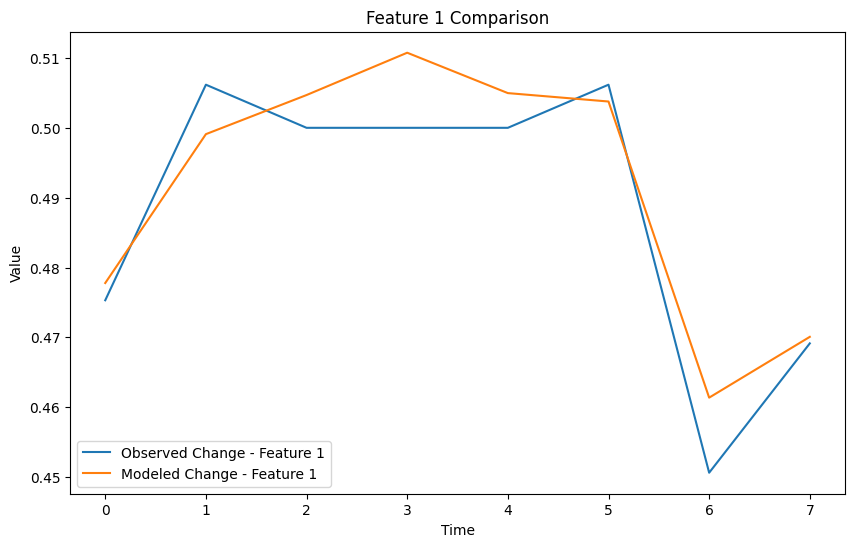

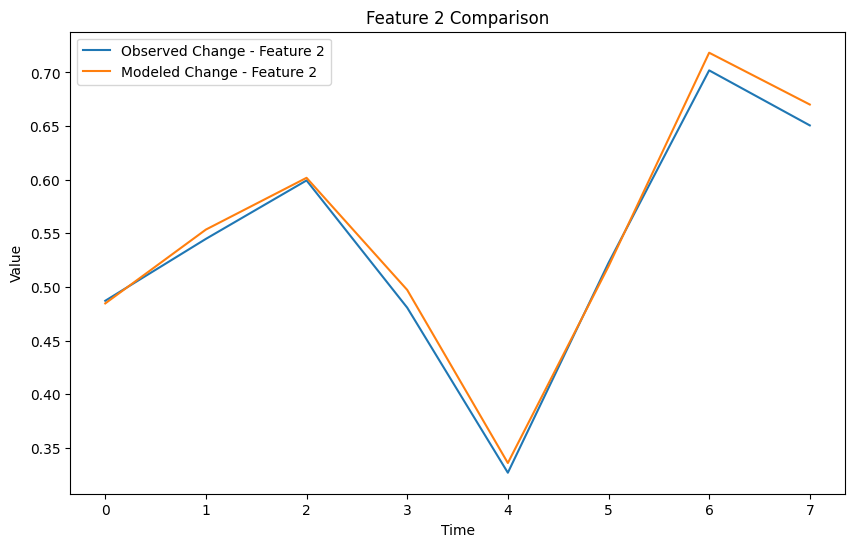

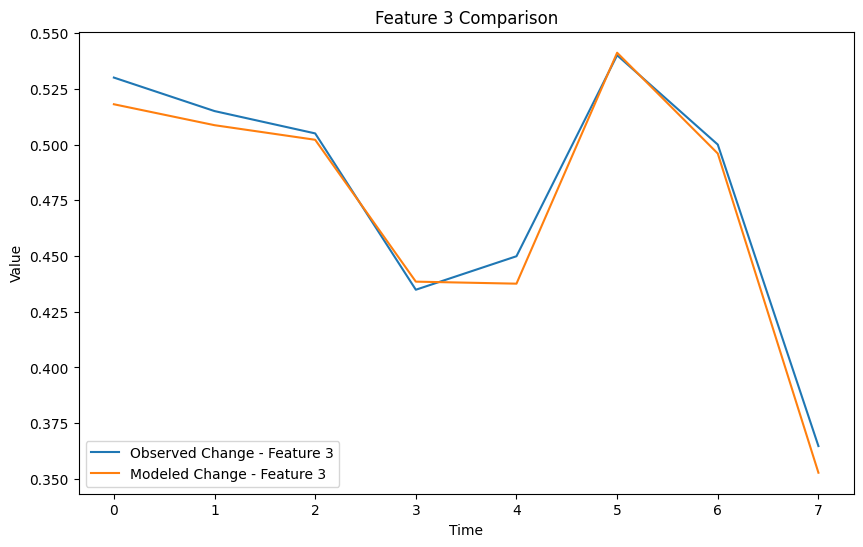

In [28]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

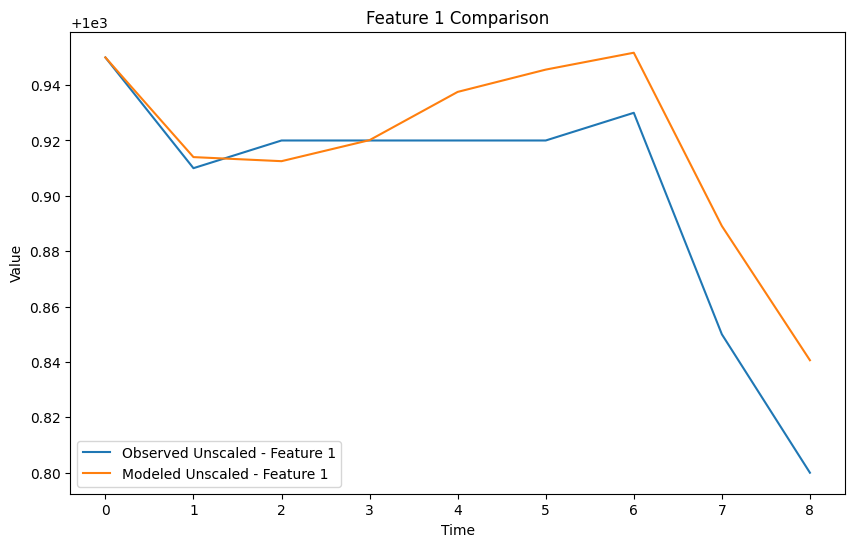

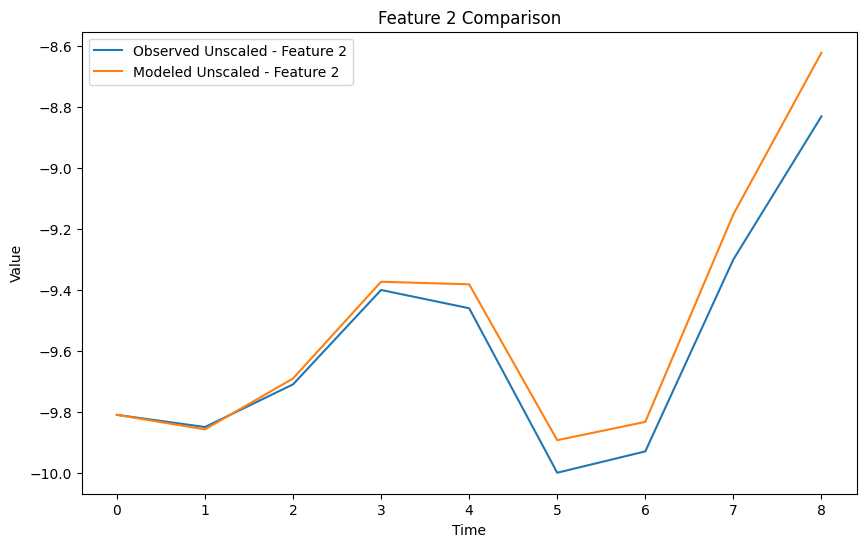

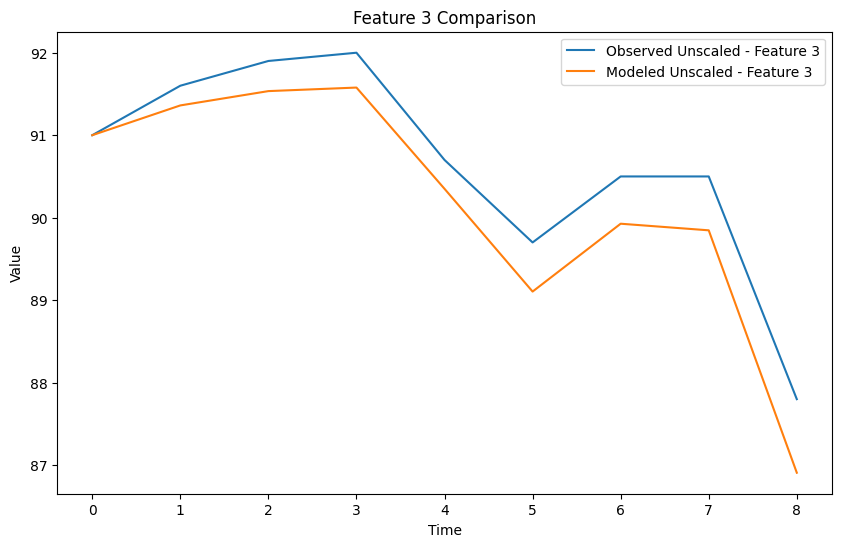

In [29]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)

In [19]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cerberus_foresight)

18052355